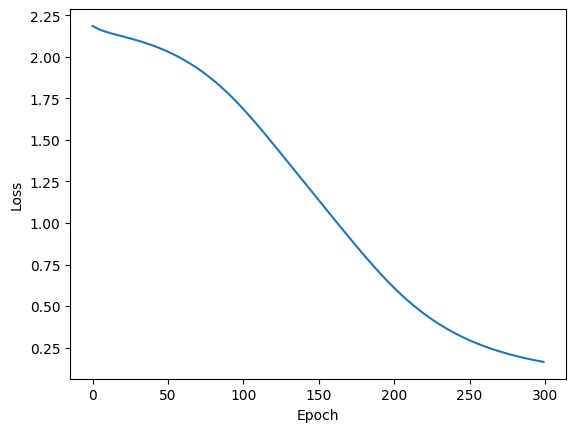

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%run basic_lstm_pytorch.ipynb

torch.manual_seed(1) # Ensure random number generation if needed.

In [58]:
raw_text = """Half a league, half a league,
Half a league onward,
All in the valley of Death
   Rode the six hundred.
“Forward, the Light Brigade!
Charge for the guns!” he said.
Into the valley of Death
   Rode the six hundred.

II
“Forward, the Light Brigade!”
Was there a man dismayed?
Not though the soldier knew
   Someone had blundered.
   Theirs not to make reply,
   Theirs not to reason why,
   Theirs but to do and die.
   Into the valley of Death
   Rode the six hundred.

III
Cannon to right of them,
Cannon to left of them,
Cannon in front of them
   Volleyed and thundered;
Stormed at with shot and shell,
Boldly they rode and well,
Into the jaws of Death,
Into the mouth of hell
   Rode the six hundred.

IV
Flashed all their sabres bare,
Flashed as they turned in air
Sabring the gunners there,
Charging an army, while
   All the world wondered.
Plunged in the battery-smoke
Right through the line they broke;
Cossack and Russian
Reeled from the sabre stroke
   Shattered and sundered.
Then they rode back, but not
   Not the six hundred.

V
Cannon to right of them,
Cannon to left of them,
Cannon behind them
   Volleyed and thundered;
Stormed at with shot and shell,
While horse and hero fell.
They that had fought so well
Came through the jaws of Death,
Back from the mouth of hell,
All that was left of them,
   Left of six hundred.

VI
When can their glory fade?
O the wild charge they made!
   All the world wondered.
Honour the charge they made!
Honour the Light Brigade,
   Noble six hundred!'"""

In [59]:
context_size = 2 # Number of words considered by the model before the target word itself.
embedding_dims = 10 
text_data = raw_text.strip().split()
ngrams = []

In [60]:
for iths in range(context_size, len(text_data)):
    context_words = []
    
    for jths in range(context_size):
        context_words.append(text_data[iths - jths - 1])
    
    context_words = context_words[::-1]
    target_word = text_data[iths]

    ngrams.append((context_words, target_word))

text_vocabulary = set(text_data)

In [61]:
text_data_index = {text_element : i for i, text_element in enumerate(text_vocabulary)}

In [62]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [63]:
losses = []
fn_loss = nn.NLLLoss()

In [64]:
ngram_test_model = NGramLanguageModeler(len(text_vocabulary), embedding_dims, context_size)

In [65]:
fn_optimization = optim.SGD(ngram_test_model.parameters(), lr=0.001)

In [66]:
gross_loss = []
# Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
for epoch in range(225):
        loss_val = 0
        for CWs, TWs in ngrams:
                context_tensor = torch.tensor([text_data_index[words] for words in CWs], dtype=torch.long)

                # Step 2. Recall that torch *accumulates* gradients. Before passing in a
                        # new instance, you need to zero out the gradients from the old
                        # instance
                ngram_test_model.zero_grad()

                # Step 3. Run the forward pass, getting log probabilities over next
                        # words
                log_probabilities = ngram_test_model(context_tensor)

                # Step 4. Compute your loss function. (Again, Torch wants the target
                        # word wrapped in a tensor)
                run_loss = fn_loss(log_probabilities, torch.tensor([text_data_index[TWs]], dtype=torch.long))

                # Step 5. Do the backward pass and update the gradient
                run_loss.backward()
                fn_optimization.step()
                # Get the Python number from a 1-element Tensor by calling tensor.item()
                loss_val += run_loss.item()
        gross_loss.append(loss_val)

# print(gross_loss)


In [67]:
print(ngram_test_model.embeddings.weight[text_data_index["rode"]])

tensor([-0.3482,  0.9648, -0.5390,  0.8504,  1.8149, -0.2590,  0.5059, -1.9650,
        -2.9700, -0.6483], grad_fn=<SelectBackward0>)


In [68]:
print(ngram_test_model.embeddings.weight[text_data_index["valley"]])

tensor([ 0.3229,  0.3080, -0.4303,  1.0569,  1.9965, -1.1875,  0.7965,  0.2544,
        -1.5967,  1.7700], grad_fn=<SelectBackward0>)


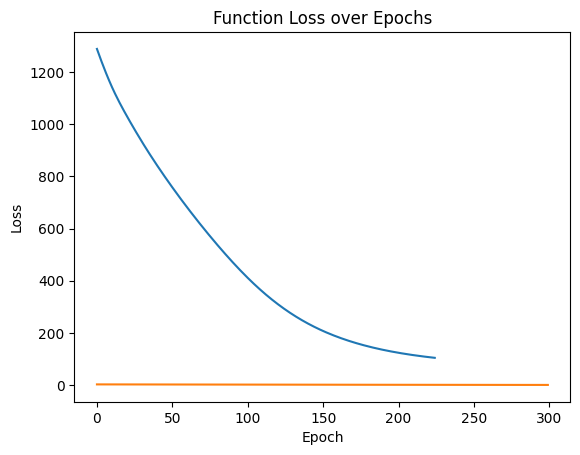

In [69]:
plt.plot(gross_loss)
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Function Loss over Epochs")
plt.show()